# Malaria Detection

### What is Malaria? 
Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.

### Why this problem?
Malaria must be recognized promptly in order to treat the patient in time and to prevent further spread of infection in the community via local mosquitoes.

Malaria should be considered a potential medical emergency and should be treated accordingly. Delay in diagnosis and treatment is a leading cause of death in malaria patients in the United States.

Malaria can be suspected based on the patient’s travel history, symptoms, and the physical findings at examination. However, for a definitive diagnosis to be made, laboratory tests must demonstrate the malaria parasites or their components.

### Some facts about Malaria
* Malaria is a **life-threatening disease** caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. *It is preventable and curable.*


* In **2017**, there were an estimated **219 million cases of malaria in 90 countries.**


* **Malaria deaths reached 435 000 in 2017.**


* The **WHO African Region** carries a disproportionately high share of the global malaria burden. In 2017, the region was home to **92% of malaria cases and 93% of malaria deaths.**


* Total funding for malaria control and elimination reached an estimated US 3.1 billion in 2017. Contributions from governments of endemic countries amounted to US 900 million, representing 28% of total funding.

#### Resources:
https://www.who.int/news-room/fact-sheets/detail/malaria 

https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html

### Our task:
We will be using https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/home dataset to build an **image-classifer** to help detect Malaria

We will do the following:

* Download & Import libraries 
* Download our data from this Kaggle Dataset 
* Explore the data
* Create DataBunch Object - FastAI Library
* Build Model (DenseNet169) - FastAI Library
* Conclude our work & Next steps

## Downloading, Improrting Libraries, and Downloading Data

In [1]:
# !pip install kaggle --upgrade
# !pip install fastai

In [2]:
from fastai import *
from fastai.vision import *

import torch
from torchvision.models import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

In [3]:
torch.backends.cudnn.enabled == True

True

In [4]:
!pwd

/notebooks/course-v3/nbs/dl1


In [5]:
# # configuring kaggle
# !mkdir .kaggle

# cred = json.dumps({"username":"USERNAME","key":"KEY"}) 
# with open('.kaggle/kaggle.json', 'w') as f:
#     f.write(cred) 

# # Configuring the file - we will run this twice (second time next block)
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [6]:
# # run for second time
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [7]:
# # making private
# !chmod 600 /root/.kaggle/kaggle.json

In [8]:
# Making directories for our data & path
!mkdir malaria_data 

path = '/notebooks/course-v3/nbs/dl1/malaria_data'

In [11]:
# downloading data
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p {path}

 99%|███████████████████████████████████████▌| 333M/337M [00:12<00:00, 38.1MB/s]
100%|████████████████████████████████████████| 337M/337M [00:12<00:00, 27.7MB/s]


In [12]:
os.listdir(path)

['cell-images-for-detecting-malaria.zip']

In [13]:
# We have to now unzip our folder
!unzip -q -n {path}/cell-images-for-detecting-malaria.zip -d {path}

In [16]:
os.listdir(path)

['cell_images', 'cell-images-for-detecting-malaria.zip']

In [17]:
# Let's remove the zip file!
!rm -rf {path}/cell-images-for-detecting-malaria.zip

In [18]:
# Turning our path to images into a FastAI path object 
images_path = f'{path}/cell_images'

images_path = Path(images_path)
images_path.ls() # exclusive to FastAI framework

[PosixPath('/notebooks/course-v3/nbs/dl1/malaria_data/cell_images/Uninfected'),
 PosixPath('/notebooks/course-v3/nbs/dl1/malaria_data/cell_images/Parasitized')]

## Exploring our Data with DataBunch API
To find out more about the **DataBunch API** I highly suggest checking out www.fast.ai and their great documentation here: https://docs.fast.ai/data_block

**FastAI's** Framework is built on top of **PyTorch** 

In [19]:
# Setting our transformations - Data Augmentations

tfms_ = get_transforms(flip_vert=True, max_zoom=0.1, max_lighting=0.1, max_warp=0)

In [24]:
# Creating our DataBunch object
seed = np.random.seed(42)
src = (ImageItemList.from_folder(images_path)
                    .random_split_by_pct(0.2, seed)
                    .label_from_folder())

def get_data(batch_size, image_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2, bs=batch_size).normalize(imagenet_stats))
    return data

In [46]:
# We will choose a image-size of 64, the original sizes are around 115x115, we will increase the size as a little trick to increase accuracy
data = get_data(64, 64)

In [47]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (22047 items)
[Category Uninfected, Category Uninfected, Category Uninfected, Category Uninfected, Category Uninfected]...
Path: /notebooks/course-v3/nbs/dl1/malaria_data/cell_images
x: ImageItemList (22047 items)
[Image (3, 118, 151), Image (3, 109, 112), Image (3, 121, 121), Image (3, 127, 157), Image (3, 133, 142)]...
Path: /notebooks/course-v3/nbs/dl1/malaria_data/cell_images;

Valid: LabelList
y: CategoryList (5511 items)
[Category Uninfected, Category Uninfected, Category Parasitized, Category Parasitized, Category Parasitized]...
Path: /notebooks/course-v3/nbs/dl1/malaria_data/cell_images
x: ImageItemList (5511 items)
[Image (3, 133, 136), Image (3, 148, 157), Image (3, 160, 121), Image (3, 133, 121), Image (3, 115, 124)]...
Path: /notebooks/course-v3/nbs/dl1/malaria_data/cell_images;

Test: None

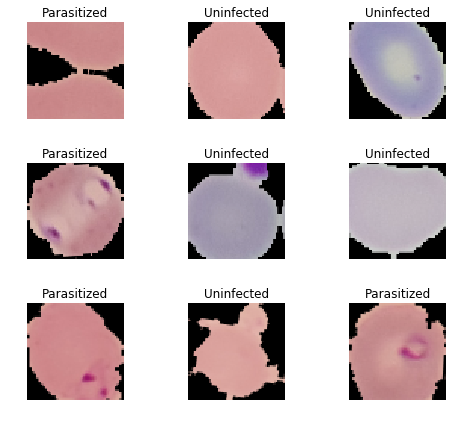

In [48]:
data.show_batch(rows=3, figsize=(7,6))

## DenseNet161
From tackling several Medical Classification tasks, I have noticed that DenseNet's Architecture performs much better than ResNet (Pre-Trained) 

In [49]:
# Arch
arch_densenet = densenet161

In [72]:
# Learner 
learn = create_cnn(data, arch_densenet, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


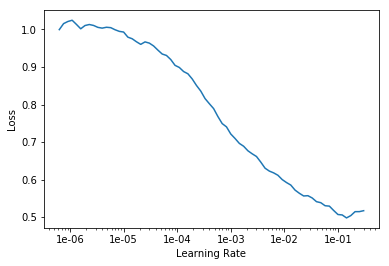

In [51]:
# finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [66]:
# Optimal learning rate
lr1 = 5e-3
lr2 = 3e-2
lr3 = 1e-2

In [73]:
# BEAT - .9731, lr2
learn.fit_one_cycle(10, slice(lr2))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.177990,0.142073,0.041553,0.958447
2,0.164599,0.115581,0.039376,0.960624
3,0.154646,0.104254,0.037380,0.962620
4,0.143580,0.220826,0.080385,0.919615
5,0.136145,0.098306,0.032299,0.967701
6,0.122996,0.129100,0.050989,0.949011
7,0.103208,0.091894,0.034295,0.965705
8,0.097947,0.077491,0.028851,0.971149
9,0.073160,0.075959,0.027400,0.972600
10,0.075412,0.075408,0.026492,0.973508


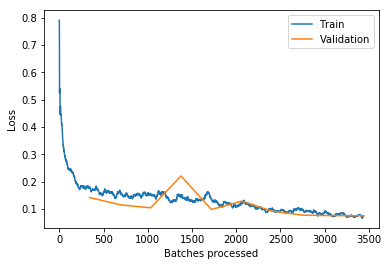

In [74]:
learn.recorder.plot_losses()

## Conclusion & Further Work
With just 10 epochs of training, we were able to achieve **97%** accuracy with a **DenseNet161** Architecture. 

With further fine-tuning & other methods we can reach closer to **99%**

What I would do to further fine-tune:
* Unfreeze all layers
* Train with for 3-5 more epochs with differential learning rates 
* Load up another databunch object, this time image_size=224 
* Repeat:
    * Train for 8-10 epochs with one_cycle
    * Unfreeze
    * Train for 3-5 epochs with differential learning rates
* Apply Test Time Augmentation 
* Test in inference 

To further finetune, if our model seems to overfit, I would include more regularization methods
* Weight Decay - grid search
* Batch Sizes 
* Momentum 
* Dropout